## Import Header

In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

from zipfile import ZipFile
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data.experimental import cardinality

from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomZoom, RandomRotation

from tensorflow.keras.applications import vgg19, VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Input, Model

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [2]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

def unzip(nm):
    with ZipFile(nm,"r") as zip:
        zip.extractall()

unzip("archive.zip")

In [3]:
train_ds = image_dataset_from_directory(
    "TB_Chest_Radiography_Database",
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    shuffle = True,
    image_size = (224,224),
    batch_size = 32,
)

val_ds = image_dataset_from_directory(
    "TB_Chest_Radiography_Database",
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    shuffle = True,
    image_size = (224,224),
    batch_size = 32,
)

Found 4200 files belonging to 2 classes.
Using 3360 files for training.
Found 4200 files belonging to 2 classes.
Using 840 files for validation.


## Plotting some images

['Normal', 'Tuberculosis']


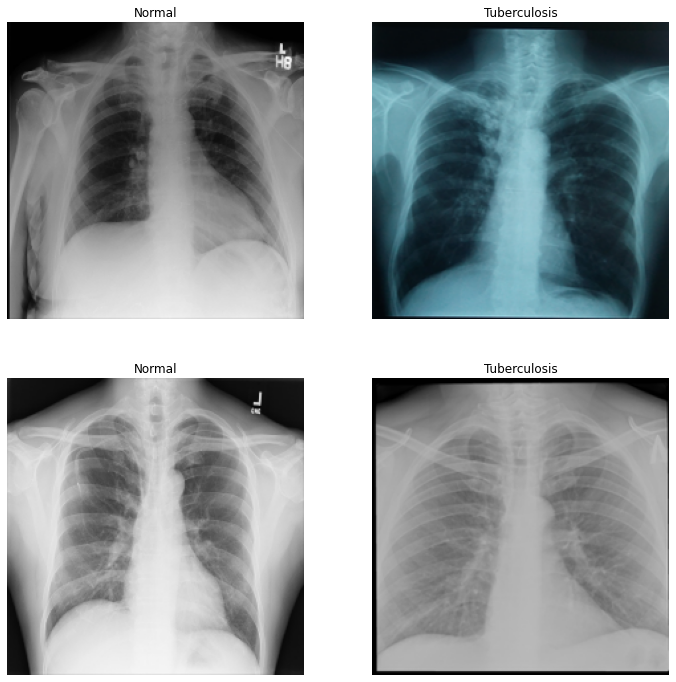

In [4]:
val_batches = cardinality(val_ds)
test_ds = val_ds.take(val_batches//5)
val_ds = val_ds.skip(val_batches//5)

class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(12,12))
for images,labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2,2,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

data_augmentation = Sequential([
    RandomZoom(0.2),
    RandomRotation(0.1),
])

## Define the model (Transfer learning with fine tuning)

In [5]:
rescale = vgg19.preprocess_input

base_model = VGG19(input_shape=(224,224,3),include_top=False,weights="imagenet")
base_model.trainable = True
base_model.summary()


fine_tune_at = 11

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

class Transfer_VGG19():
    def model(self,input):
        self.x = data_augmentation(input)
        self.x = rescale(self.x)
        self.x = base_model(self.x,training=False)
        self.x = GlobalAveragePooling2D()(self.x)
        self.x = Flatten()(self.x)
        self.x = Dense(128,activation="relu")(self.x)
        self.x = Dropout(0.4,seed=42)(self.x)
        self.x = Dense(64,activation="relu")(self.x)
        self.x = Dropout(0.4,seed=42)(self.x)
        self.outputs = Dense(2,activation="sigmoid")(self.x)
        self.model = Model(input,self.outputs,name="Transfer_VGG19")
        return self.model

TVGG19 = Transfer_VGG19()
model = TVGG19.model(Input(shape=(224,224,3)))
model.summary()
model.compile(Adam(learning_rate=1e-5),SparseCategoricalCrossentropy(),metrics=["accuracy"])

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
if __name__=="__main__":
    loss0,accuracy0 = model.evaluate(val_ds)
    print("Initial loss: {:.2f} %".format(100*loss0))
    print("Initial accuracy: {:.2f} %".format(100*accuracy0))
    checkpoint = ModelCheckpoint("tuberculosis.hdf5",save_weights_only=False,monitor="val_loss",save_best_only=True)
    model.fit(train_ds,epochs=5,validation_data=val_ds,callbacks=[checkpoint])
    best = load_model("tuberculosis.hdf5")
    val_loss,val_accuracy = best.evaluate(val_ds)
    test_loss,test_accuracy = best.evaluate(test_ds)
    print("\nVal accuracy: {:.2f} %".format(100*val_accuracy))
    print("Val loss: {:.2f} %".format(100*val_loss))
    print("\nTest accuracy: {:.2f} %".format(100*test_accuracy))
    print("Test loss: {:.2f} %".format(100*test_loss))

22/22 [==============================] - 19s 415ms/step - loss: 1.8624 - accuracy: 0.3397
Initial loss: 186.24 %
Initial accuracy: 33.97 %
Epoch 1/5
105/105 [==============================] - 63s 573ms/step - loss: 0.4256 - accuracy: 0.8491 - val_loss: 0.1113 - val_accuracy: 0.9603
Epoch 2/5
105/105 [==============================] - 57s 544ms/step - loss: 0.1644 - accuracy: 0.9354 - val_loss: 0.0479 - val_accuracy: 0.9838
Epoch 3/5
105/105 [==============================] - 58s 546ms/step - loss: 0.1078 - accuracy: 0.9601 - val_loss: 0.0628 - val_accuracy: 0.9706
Epoch 4/5
105/105 [==============================] - 58s 547ms/step - loss: 0.0813 - accuracy: 0.9738 - val_loss: 0.0170 - val_accuracy: 0.9956
Epoch 5/5
5/5 [==============================] - 2s 288ms/step - loss: 0.0312 - accuracy: 0.9937

Val accuracy: 99.56 %
Val loss: 1.67 %

Test accuracy: 99.37 %
Test loss: 3.12 %
